# LDA Topic Modeling in Python - Liberals Blog
- __Date__: June 29, 2020
-- __Updated__: August 24, 2020
- __Author__: Karim Khan
- __Description__: This Notebook demonstrates LDA labelled topic analysis for 36 blogs scraped from the Liberal Party of Canada's News Website. 

- <strong>Reference</strong>: This work has been inspired by the following [article](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0).

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Install all required modules and their dependencies

In [4]:
!pip install requests
!pip install beautifulsoup4
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install nltk
!pip install -U gensim
!pip install matplotlib
!pip install seaborn
!pip install lxml
!pip install spacy
!pip install pyldavis
print("Install completed successfully!")

     |████████████████████████████████| 24.2MB 44.4MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 1.6MB 4.4MB/s 
     |████████████████████████████████| 552kB 19.6MB/s 
  Created wheel for pyldavis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=41b6f55b6a987a94fa5a074ac1ba1e5be2611932e9e1978b2e1568ce82518e48
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=4ac3d5698a5faabbd878a5f486e1775a6165c9e9c45c40160142f41977bb528f
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyldavis funcy
Install completed successfully!


## Import LDA Topic Modeling Libraries

In [5]:
import pandas as pd #Python's Data structure library
import re #regular expressions, used in text cleaning
import string
import seaborn as sns #plotting library
import matplotlib #plotting library
import matplotlib.pyplot as plt #plotting library


import gensim #Scalable statistical semantics
              #Analyze plain-text documents for semantic structure
              #Retrieve semantically similar documents

from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim.models import CoherenceModel

import pyLDAvis #Python library for interactive topic model visualization
import pyLDAvis.gensim

import spacy #library for advanced Natural Language Processing in Python

#uncomment to download module for first-time use 
# !python3 -m spacy download en_core_web_sm 

import en_core_web_sm

# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import numpy as np #Python's scientific computing library (Arrays and Matrices)

import tqdm #tqdm means "progress" in Arabic (taqadum, تقدّم) 
            #Instantly make your loops show a smart progress meter - 
            #just wrap any iterable with tqdm(iterable), and you're done! 

from pprint import pprint # Print high-scoring keywords in modeled topics

print("Libraries imported successfully!")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Libraries imported successfully!


## Check latest gensim is successfully installed (3.8.3)
### This is important for Topic model iterations later on.

In [6]:
gensim.__version__

'3.8.3'

## Pick the latest 40 blogs from the Scraper and read into a CSV

In [8]:
# Load the latest 40 blogs from the Liberals website
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Liberals_Num_Posts.csv')
df.head()

,Blog No.,Title,Subtitle,Date,Link,Content
0,1,Snapshot: Supporting Canadians and stabilizing...,"Throughout this pandemic, Justin Trudeau and t...","\n\t\t\t\t\t\t\t\tJuly 8, 2020\t\t\t\t\t\t\t\t",https://liberal.ca/fiscal-snapshot/,Snapshot: Supporting Canadians and stabilizing...
1,2,Justin Trudeau’s address to Parliament on anti...,"We must stand together against racism, discrim...","\n\t\t\t\t\t\t\t\tJune 2, 2020\t\t\t\t\t\t\t\t",https://liberal.ca/justin-trudeaus-address-to-...,Justin Trudeau’s address to Parliament on anti...
2,3,COVID-19 Response: More support for Canadian s...,No Canadian should have to choose between putt...,"\n\t\t\t\t\t\t\t\tMay 12, 2020\t\t\t\t\t\t\t\t",https://liberal.ca/covid-19-response-more-supp...,COVID-19 Response: More support for Canadian s...
3,4,The Latest,Here’s a quick breakdown some of the steps our...,"\n\t\t\t\t\t\t\t\tApril 24, 2020\t\t\t\t\t\t\t\t",https://liberal.ca/the-latest/,The Latest\t\t\t\t\t\t\t\t\t\n\n\n\t\t\t\t\t\t...
4,5,Survey: Your Movement 2020,We want to hear from you: What tools do you ne...,"\n\t\t\t\t\t\t\t\tApril 23, 2020\t\t\t\t\t\t\t\t",https://liberal.ca/survey-your-movement-2020/,Survey: Your Movement 2020\t\t\t\t\t\t\t\t\t\n...


# LDA Topic Modeling
## Data Cleaning

- We will only include the detailed content of the articles in our analysis, ruling out all other parameters.
- Create new dataframe only including the content.

In [9]:
df_content = df[[' Content']]
print("The total number of scraped articles: ", len(df))
df_content.head()

The total number of scraped articles:  40


,Content
0,Snapshot: Supporting Canadians and stabilizing...
1,Justin Trudeau’s address to Parliament on anti...
2,COVID-19 Response: More support for Canadian s...
3,The Latest\t\t\t\t\t\t\t\t\t\n\n\n\t\t\t\t\t\t...
4,Survey: Your Movement 2020\t\t\t\t\t\t\t\t\t\n...


## Drop rows returning no content

Some of the scraped blogs have no content due to inconsistent HTML structure between them. To handle those, an exception is added to the Scraper function to return the content of the main HTML tag containing the corpus, which is consistent in the majority of the blogs posted on the Liberal Party's website. However, a few blogs containing public reach-out content (e.g. a Questionnaire, an Internship opportunity, Invitation to participate in a Public forum, etc.) have different HTML tags. As such, the Scraper function is coded to return an exception named "NaN" to flag those blogs. With that said, the links to those blogs are available in the original dataset if the user wishes to inspect them.

In [10]:
df_content.dropna(inplace=True)
df_content = df_content.reset_index(drop=True) # drop=True option avoids adding new index column with old index values
print("The number of actual articles with content: ", len(df_content))
df_content.head()

The number of actual articles with content:  38


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Content
0,Snapshot: Supporting Canadians and stabilizing...
1,Justin Trudeau’s address to Parliament on anti...
2,COVID-19 Response: More support for Canadian s...
3,The Latest\t\t\t\t\t\t\t\t\t\n\n\n\t\t\t\t\t\t...
4,Survey: Your Movement 2020\t\t\t\t\t\t\t\t\t\n...


## Evaluate what needs to be cleaned
The following code shows sample content for the first blog. This is applied to the entire corpus and is an integral step in the text cleaning stage, as it helps detect all anomalies (which will be presented in the following code blocks) that need to be removed prior the topic modeling step.  

In [11]:
df_content.values[0]

array(['Snapshot: Supporting Canadians and stabilizing our economy\t\t\t\t\t\t\t\t\t\n\n\n\t\t\t\t\t\t\t\tJuly 8, 2020\t\t\t\t\t\t\t\t\n\n\n\t\t\t\t\t\t\t\t\t\tShare\t\t\t\t\t\t\t\t\t\n\n\n\n\n\n\n\nThroughout this pandemic, Justin Trudeau and the Liberal government have been working hard to make sure you and your family are safe and supported during this challenging time.\nThe fiscal snapshot presented by Bill Morneau today highlights how Justin Trudeau and the Liberal government have been able to stabilize the economy and keep Canadians supported. \nThis support is the largest peacetime investment in Canada’s history, and has allowed millions of Canadian families and businesses to keep receiving income during a time of uncertainty.\nHere are few highlights of how Canadian families, workers, and small businesses are being supported, by the numbers:\n\nMore than 8.16 million people have received support from the Canada Emergency Response Benefit, providing $2,000 a month to Canadians w

## Use Regular Expressions to apply rounds of text cleaning

In [12]:
# Remove punctuation
df_content['Content_processed'] = df_content[' Content'].map(lambda x: re.sub('[,!?]', '', x))

# Convert the text to lowercase
df_content['Content_processed'] = df_content['Content_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
df_content['Content_processed'].head()

0    snapshot: supporting canadians and stabilizing...
1    justin trudeau’s address to parliament on anti...
2    covid-19 response: more support for canadian s...
3    the latest\t\t\t\t\t\t\t\t\t\n\n\n\t\t\t\t\t\t...
4    survey: your movement 2020\t\t\t\t\t\t\t\t\t\n...
Name: Content_processed, dtype: object

## Tokenize words and further clean-up text
Let’s tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.

In [13]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = df_content.Content_processed.values.tolist()
data_words = list(sent_to_words(data))

print(data_words[:1]) #Print words from the first blog

[['snapshot', 'supporting', 'canadians', 'and', 'stabilizing', 'our', 'economy', 'july', 'share', 'throughout', 'this', 'pandemic', 'justin', 'trudeau', 'and', 'the', 'liberal', 'government', 'have', 'been', 'working', 'hard', 'to', 'make', 'sure', 'you', 'and', 'your', 'family', 'are', 'safe', 'and', 'supported', 'during', 'this', 'challenging', 'time', 'the', 'fiscal', 'snapshot', 'presented', 'by', 'bill', 'morneau', 'today', 'highlights', 'how', 'justin', 'trudeau', 'and', 'the', 'liberal', 'government', 'have', 'been', 'able', 'to', 'stabilize', 'the', 'economy', 'and', 'keep', 'canadians', 'supported', 'this', 'support', 'is', 'the', 'largest', 'peacetime', 'investment', 'in', 'canada', 'history', 'and', 'has', 'allowed', 'millions', 'of', 'canadian', 'families', 'and', 'businesses', 'to', 'keep', 'receiving', 'income', 'during', 'time', 'of', 'uncertainty', 'here', 'are', 'few', 'highlights', 'of', 'how', 'canadian', 'families', 'workers', 'and', 'small', 'businesses', 'are', 'b

## Phrase Modeling: Bi-grams and Tri-grams
- Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring. Some examples in our example are: ‘mr_speaker’, ‘prime_minister’, ‘middle_class’ etc.

- Gensim’s Phrases model can build and implement the bigrams, trigrams, n-grams and more. The two important arguments to Phrases are <strong>min_count</strong> and <strong>threshold</strong>.

- The higher the values of these param, the harder it is for words to be combined.

In [14]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

## Remove Stopwords, Make Bigrams and Lemmatize Text
- The phrase models are ready. Let’s define the functions to remove the stopwords, make n-grams and lemmatization and call them sequentially.

- Stemming and Lemmatization both generate the root form of the inflected words. The difference is that stem might not be an actual word whereas, lemma is an actual language word.

In [15]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'also', 'make', 'take', 'trouvaient', 'tranchee', 'lendemain', 'prendraient', 
                  'nous', 'souvenon', 'leur', 'connaisson', 'autre', 'malheureusement', 'pleureron', 'si', 'prenon', 'toute', 'necessaire', 'la'
                  'empirer', 'somme', 'devant', 'pour', 'responsabilite', 'chambre', 'et', 'venon', 'aide', 'biographie', 'share', 'em'])

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

print("Functions created successfully!")

Functions created successfully!


SpaCy is an open-source library for advanced Natural Language Processing in Python. It is designed specifically for production use and helps build applications that process and “understand” large volumes of text. It can be used to build information extraction or natural language understanding systems, or to pre-process text for deep learning. Some of the features provided by spaCy are- Tokenization, Parts-of-Speech (PoS) Tagging, Text Classification and Named Entity Recognition.

In [16]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = en_core_web_sm.load()

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['snapshot', 'support', 'canadian', 'stabilize', 'economy', 'pandemic', 'liberal', 'government', 'work', 'hard', 'sure', 'family', 'safe', 'support', 'challenging', 'time', 'fiscal', 'snapshot', 'present', 'today', 'liberal', 'government', 'able', 'stabilize', 'economy', 'keep', 'canadian', 'support', 'support', 'large', 'peacetime', 'investment', 'history', 'allow', 'million', 'canadian', 'family', 'business', 'keep', 'receive', 'income', 'time', 'uncertainty', 'highlight', 'canadian', 'family', 'worker', 'small', 'business', 'support', 'number', 'people', 'receive', 'benefit', 'provide', 'month', 'canadian', 'lose', 'income', 'due', 'covid', 'canadian', 'family', 'receive', 'special', 'time', 'increase', 'month', 'help', 'high', 'cost', 'raise', 'kid', 'employee', 'support', 'help', 'stay', 'workforce', 'return', 'work', 'low', 'modest', 'income', 'individual', 'family', 'receive', 'special', 'time', 'payment', 'gst', 'credit', 'average', 'single', 'adult', 'receive', 'additional', 

## Data Transformation: Corpus and Dictionary
### The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them.

In [17]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1]) # view first article in corpus

print("\nNumber of articles with unique words and frequency are:",len(corpus))

[[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 3), (10, 1), (11, 3), (12, 10), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 4), (29, 2), (30, 2), (31, 1), (32, 2), (33, 5), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 6), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 3), (46, 1), (47, 1), (48, 1), (49, 1), (50, 3), (51, 1), (52, 1), (53, 1), (54, 5), (55, 1), (56, 1), (57, 1), (58, 1), (59, 4), (60, 1), (61, 1), (62, 1), (63, 1), (64, 4), (65, 1), (66, 1), (67, 1), (68, 2), (69, 1), (70, 1), (71, 2), (72, 1), (73, 2), (74, 1), (75, 8), (76, 1), (77, 1), (78, 1), (79, 1), (80, 2), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 2), (87, 2), (88, 2), (89, 1), (90, 2), (91, 1), (92, 1), (93, 1), (94, 1), (95, 3), (96, 10), (97, 2), (98, 1), (99, 1), (100, 1), (101, 6), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 2), (110, 

- Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).
- For example, (0, 1) above implies, word id 0 occurs one time in the first document. Likewise, word id 1 occurs twice and so on.
- In the corpus shown above, there are 180 unique words in the first article

## Base Model

We have everything required to train the base LDA model. In addition to the corpus and dictionary, you need to provide the number of topics as well. Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior (we’ll use default for the base model).

- <strong>chunksize</strong> controls how many documents are processed at a time in the training algorithm. Increasing chunksize will speed up training, at least as long as the chunk of documents easily fit into memory.


- <strong>passes</strong> controls how often we train the model on the entire corpus (set to 10). Another word for passes might be “epochs”. iterations is somewhat technical, but essentially it controls how often we repeat a particular loop over each document. It is important to set the number of “passes” and “iterations” high enough.

- <strong>Note</strong>: The <code>random_state</code> argument passed to the model was set to a seed value to ensure that results are reproducible everytime the iteration is run.

In [18]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=np.random.seed(0),
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

## View the topics in LDA model

- The above LDA model is built with 10 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.


- You can see the keywords for each topic and the weightage (importance) of each keyword using lda_model.print_topics()

In [19]:
# Print the strongest keywords in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.023*"pollution" + 0.018*"source" + 0.015*"carbon" + 0.010*"economy" + '
  '0.010*"emission" + 0.008*"pricing" + 0.008*"federal" + 0.008*"price" + '
  '0.007*"policy" + 0.007*"create"'),
 (1,
  '0.018*"people" + 0.012*"fight" + 0.009*"stand" + 0.008*"hatred" + '
  '0.007*"day" + 0.007*"year" + 0.007*"time" + 0.007*"world" + '
  '0.007*"violence" + 0.006*"country"'),
 (2,
  '0.017*"canadian" + 0.014*"trade" + 0.012*"world" + 0.010*"work" + '
  '0.010*"international" + 0.008*"woman" + 0.007*"new" + 0.007*"global" + '
  '0.007*"need" + 0.007*"government"'),
 (3,
  '0.014*"liberal" + 0.013*"canadian" + 0.012*"plan" + 0.010*"real" + '
  '0.009*"new" + 0.008*"conservative" + 0.007*"want" + 0.007*"family" + '
  '0.007*"government" + 0.006*"team"'),
 (4,
  '0.022*"canadian" + 0.018*"liberal" + 0.014*"work" + 0.013*"make" + '
  '0.013*"community" + 0.012*"new" + 0.010*"team" + 0.009*"day" + 0.009*"help" '
  '+ 0.008*"movement"'),
 (5,
  '0.027*"canadian" + 0.022*"support" + 0.015*"seni

## Coherence Measures Overview
Let’s take a quick look at different coherence measures, and how they are calculated:

- <strong>C_v</strong> measure is based on a sliding window, one-set segmentation of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity


- <strong>C_p</strong> is based on a sliding window, one-preceding segmentation of the top words and the confirmation measure of Fitelson’s coherence


- <strong>C_uci</strong> measure is based on a sliding window and the pointwise mutual information (PMI) of all word pairs of the given top words


- <strong>C_umass</strong> is based on document cooccurrence counts, a one-preceding segmentation and a logarithmic conditional probability as confirmation measure


- <strong>C_npmi</strong> is an enhanced version of the C_uci coherence using the normalized pointwise mutual information (NPMI)


- <strong>C_a</strong> is based on a context window, a pairwise comparison of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity

## Compute Model Perplexity and Coherence Score

### Let’s calculate the baseline coherence score

In [20]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4113879344167515


## Hyperparameter Tuning

First, let’s differentiate between model hyperparameters and model parameters:

- <strong>Model hyperparameters</strong> can be thought of as settings for a machine learning algorithm that are tuned by the data scientist before training. Examples would be the number of trees in the random forest, or in our case, number of topics K


- <strong>Model parameters</strong> can be thought of as what the model learns during training, such as the weights for each word in a given topic

- <strong>Note</strong>: The <code>random_state</code> argument passed to the model was set to a seed value to ensure that results are reproducible everytime the iteration is run.

Now that we have the baseline coherence score for the default LDA model, let’s perform a series of sensitivity tests to help determine the following model hyperparameters:

1) Number of Topics (K)

2) Dirichlet hyperparameter alpha: Document-Topic Density

3) Dirichlet hyperparameter beta: Word-Topic Density

We’ll perform these tests in sequence, one parameter at a time by keeping others constant and run them over the complete validation corpus set. We’ll use <strong>C_v</strong> as our choice of metric for performance comparison.

In [21]:
# Supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=np.random.seed(0),
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

### Let’s call the function, and iterate it over the range of topics, alpha, and beta parameter values

In [22]:
# # Takes a long time - Run it once and save results to CSV file.
# grid = {}
# grid['Validation_Set'] = {}

# # Topics range
# min_topics = 2
# max_topics = 11
# step_size = 1
# topics_range = range(min_topics, max_topics, step_size)

# # Alpha parameter
# alpha = list(np.arange(0.01, 1, 0.3))
# alpha.append('symmetric')
# alpha.append('asymmetric')

# # Beta parameter
# beta = list(np.arange(0.01, 1, 0.3))
# beta.append('symmetric')

# # Validation sets
# num_of_docs = len(corpus)
# corpus_set = [corpus]

# corpus_title = ['100% Corpus']

# model_results = {'Validation_Set': [],
#                  'Topics': [],
#                  'Alpha': [],
#                  'Beta': [],
#                  'Coherence': []
#                 }

# # Can take a long time to run
# if 1 == 1:
#     pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
#     # iterate through validation corpuses
#     for i in range(len(corpus_set)):
#         # iterate through number of topics
#         for k in topics_range:
#             # iterate through alpha values
#             for a in alpha:
#                 # iterare through beta values
#                 for b in beta:
#                     # get the coherence score for the given parameters
#                     cv = compute_coherence_values(corpus=corpus_set[i], dictionary=id2word, 
#                                                   k=k, a=a, b=b)
#                     # Save the model results
#                     model_results['Validation_Set'].append(corpus_title[i])
#                     model_results['Topics'].append(k)
#                     model_results['Alpha'].append(a)
#                     model_results['Beta'].append(b)
#                     model_results['Coherence'].append(cv)
                    
#                     pbar.update(1)
                    
#     pd.DataFrame(model_results).to_csv('/content/drive/My Drive/Colab Notebooks/lda_tuning_results.csv', index=False)
#     pbar.close()

## Investigate Results

Ranking the resulting dataset by decreasing Coherence score, five plots comparing the Coherence (C_v) vs. Number of Topics for different combinations of Alpha and Beta have been examined. Three plots conclude that the optimum number of topics (K) is 8.

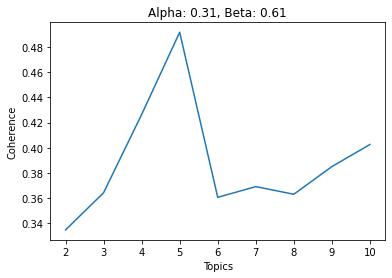

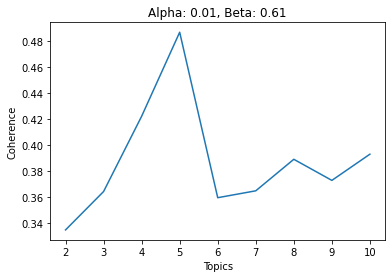

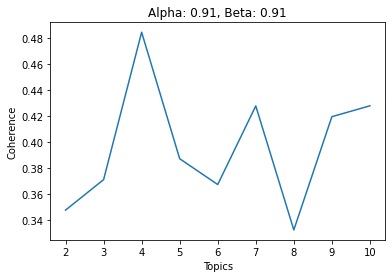

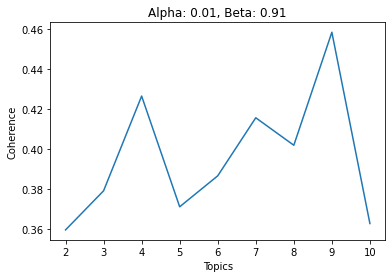

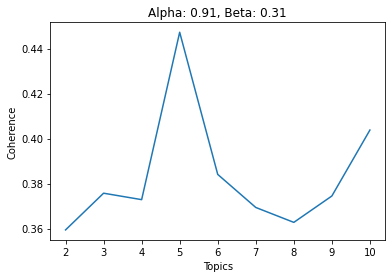

In [23]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/lda_tuning_results.csv')
df_filter_0 = df[(df.Alpha == '0.31') & (df.Beta == '0.61')]
sns.lineplot(x = "Topics", y = "Coherence", data=df_filter_0).set_title("Alpha: 0.31, Beta: 0.61")
plt.show()

df_filter_1 = df[(df.Alpha == '0.01') & (df.Beta == '0.61')]
sns.lineplot(x = "Topics", y = "Coherence", data=df_filter_1).set_title("Alpha: 0.01, Beta: 0.61")
plt.show()

df_filter_2 = df[(df.Alpha == '0.9099999999999999') & (df.Beta == '0.9099999999999999')]
sns.lineplot(x = "Topics", y = "Coherence", data=df_filter_2).set_title("Alpha: 0.91, Beta: 0.91")
plt.show()

df_filter_3 = df[(df.Alpha == '0.01') & (df.Beta == '0.9099999999999999')]
sns.lineplot(x = "Topics", y = "Coherence", data=df_filter_3).set_title("Alpha: 0.01, Beta: 0.91")
plt.show()

df_filter_4 = df[(df.Alpha == '0.9099999999999999') & (df.Beta == '0.31')]
sns.lineplot(x = "Topics", y = "Coherence", data=df_filter_4).set_title("Alpha: 0.91, Beta: 0.31")
plt.show()

## Final Model Training
Based on the above plots, models with the highest Coherence scores suggest optimal number of topics = 5.

Let’s train the model with highest Coherence score (C_v = 0.492) resulting from the previous iteration function, composed of the following hyperparameters:

- Number of Topics (K) = 5
- Alpha = 0.31
- Beta = 0.61

That yields approx. <strong>27%</strong> improvement over the baseline score.

In [24]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=np.random.seed(0),
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.31,
                                           eta=0.61)

## Topic Labelling

The 8 topics inferred from the highest-scoring keywords in the model seem semantically similar and interpretable in terms of human-readability. It can also be noted that most of these topics talk about Government support plans as inferred from the topic labels. 

The proposed resulting Topic Labels are:

1) Canadian Government Stance on Climate Change 

2) Canadian Government Support Plan for Families & Businesses

3) Canadian Government Trade Support Plan

4) Canadian Government Student & Work Support Plan

5) Canadian Liberal Government Support Plan to Communities

In [25]:
# Print the strongest keywords in the 5 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.004*"pollution" + 0.003*"carbon" + 0.002*"pricing" + 0.002*"source" + '
  '0.002*"rebate" + 0.002*"efficient" + 0.002*"effective" + 0.001*"cleaner" + '
  '0.001*"price" + 0.001*"emission"'),
 (1,
  '0.019*"canadian" + 0.014*"support" + 0.010*"help" + 0.010*"business" + '
  '0.009*"family" + 0.007*"government" + 0.007*"keep" + 0.006*"time" + '
  '0.006*"people" + 0.005*"new"'),
 (2,
  '0.010*"canadian" + 0.008*"world" + 0.007*"trade" + 0.007*"woman" + '
  '0.006*"work" + 0.006*"international" + 0.006*"people" + 0.005*"new" + '
  '0.005*"need" + 0.005*"support"'),
 (3,
  '0.013*"canadian" + 0.010*"government" + 0.009*"support" + 0.007*"work" + '
  '0.007*"new" + 0.006*"student" + 0.006*"need" + 0.006*"plan" + '
  '0.006*"liberal" + 0.005*"invest"'),
 (4,
  '0.018*"canadian" + 0.012*"liberal" + 0.010*"support" + 0.010*"work" + '
  '0.008*"new" + 0.008*"team" + 0.008*"community" + 0.007*"help" + '
  '0.007*"make" + 0.006*"real"')]


## Visualize Topics

### Setting λ  = 1 results in the familiar ranking of terms in decreasing order of their topic-specific probability

In [26]:
pyLDAvis.enable_notebook()

LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.045675  0.017726       1        1  30.596266
2      0.049027  0.055676       2        1  29.055071
4     -0.038610  0.010657       3        1  21.305523
1     -0.028184 -0.041739       4        1  18.437279
0      0.063442 -0.042321       5        1   0.605867, topic_info=           Term       Freq      Total Category  logprob  loglift
1169  pollution  14.000000  14.000000  Default  30.0000  30.0000
1608      trade  25.000000  25.000000  Default  29.0000  29.0000
59      liberal  62.000000  62.000000  Default  28.0000  28.0000
1218      world  38.000000  38.000000  Default  27.0000  27.0000
54         keep  30.000000  30.000000  Default  26.0000  26.0000
...         ...        ...        ...      ...      ...      ...
1069     carbon   0.200519   7.894803   Topic5  -5.8203   1.4332
1169  pollution   0.253184  14.257366   Topic5  -5.5871   1.0754
1813     source   0.127358  25.906422   Topic5  -6.2742  -0.2090
1517      price   0.090137   7.544741   Topic5  -6.6199   0.6790
1015   emission   0.085476  11.025855   Topic5  -6.6730   0.2465

[312 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1262      1  0.405785     achieve
1262      2  0.405785     achieve
1238      3  0.152667          ad
1238      4  0.610666          ad
2         1  0.665612  additional
...     ...       ...         ...
540       1  0.335146        year
540       2  0.311207        year
540       3  0.215451        year
540       4  0.143634        year
2225      1  0.561604         yuy

[563 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 5, 2, 1])